<a href="https://colab.research.google.com/github/FuturisticLover123/labs/blob/main/lab10/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

In [ ]:
x, y  = make_classification(n_samples=100, n_features=2, n_redundant=0, n_classes=4, n_clusters_per_class=1, random_state=23, class_sep=3)

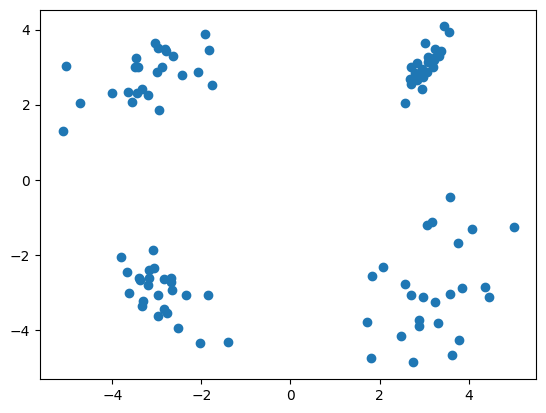

In [ ]:
plt.scatter(x[:,0], x[:,1])

In [ ]:
#task 1

In [ ]:
class KMeans:
  def __init__(self, k=3, max_iter=100):
    self.labels_, self.k= list(range(k)), k
    self.max_iter=max_iter

  def _init_one_center(self, x):
    return np.array([np.random.uniform(np.min(x[:, i]) , np.max(x[: , i])) for i in range(x.shape[1])])

  def _init_centers(self, x):
    return np.array([self._init_one_center(x) for _ in self.labels_])

  def fit(self, x):
    self.cluster_centers_ = self._init_centers(x)
    for n in range(self.max_iter):
      new_clusters = self.kmeans_step(x)
      if np.array_equal(new_clusters, self.cluster_centers_):
        return self
      self.cluster_centers_ = new_clusters
    return self


  def kmeans_step(self, x):
    clusters = [list() for _ in self.labels_]
    for point in x:
      distances = [np.linalg.norm(point - center) for center in self.cluster_centers_]
      clusters[np.argmin(distances)].append(point)

    new_centers = np.array([np.mean(cluster,axis=0) if len(cluster) > 0 else self._init_one_center(x) for cluster in clusters])
    return new_centers

  def classify(self, x):
    return np.argmin([np.linalg.norm(x - center) for center in self.cluster_centers_])

  def predict(self, x):
    return np.array([self.classify(x_i) for x_i in x])






In [ ]:
def picture(y_out, centers, labels, ax):
  colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))

  for color, m in zip(colors, labels):
    points = x[np.where(y_out == m)[0], :]
    ax.scatter(points[:, 0], points[:, 1], c=color)
    ax.scatter(*centers[m] , c='red', s=100)

In [ ]:
class SuperInitKMeans(KMeans):
  def __init__(self, k=3, n_steps=5, n_models=5):
    super().__init__(k=k)
    self.n_steps, self.n_models =n_steps, n_models

  def _init_centers(self, x):
    for _ in range(self.n_models):
      return np.mean([KMeans(k=self.k, max_iter=self.n_steps).fit(x).cluster_centers_ for _ in range(self.n_models)], axis=0)


<ipython-input-17-7ddc83e08123>:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], c=color)


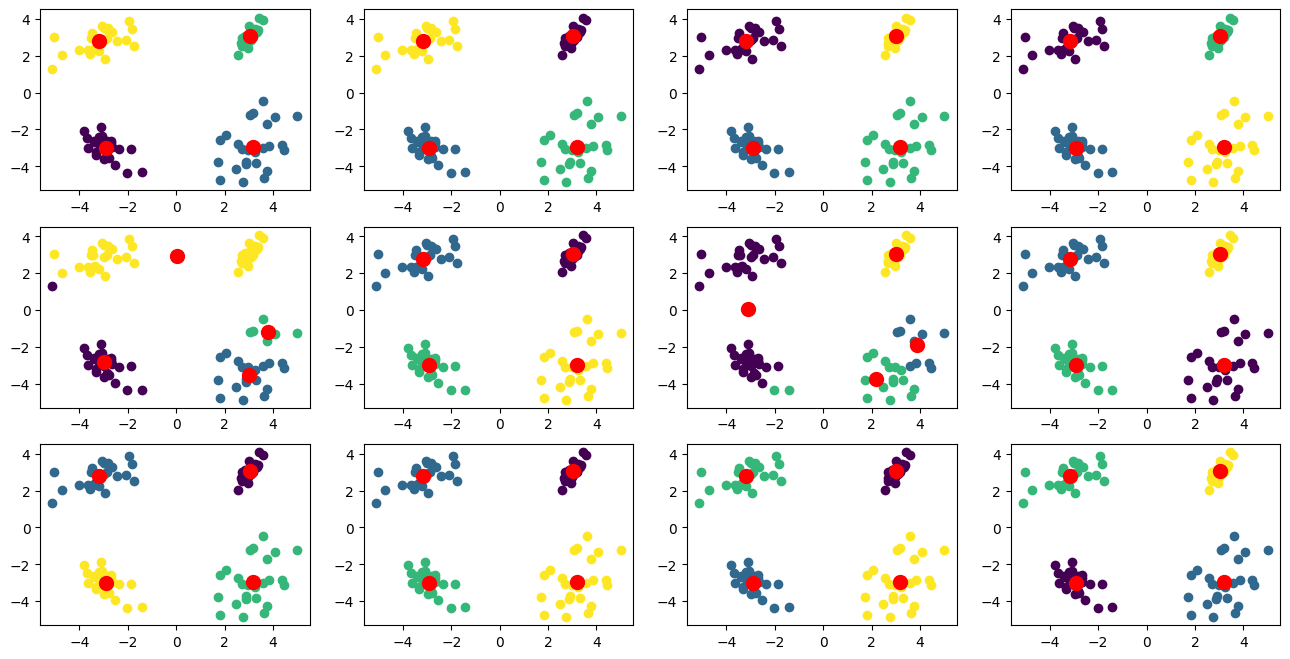

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 8))
for ax, _ in zip(axes.ravel(), range(12)):
    model = SuperInitKMeans(k=4, n_steps=2, n_models=5).fit(x)
    picture(model.predict(x), model.cluster_centers_, model.labels_, ax)

<ipython-input-17-7ddc83e08123>:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], c=color)


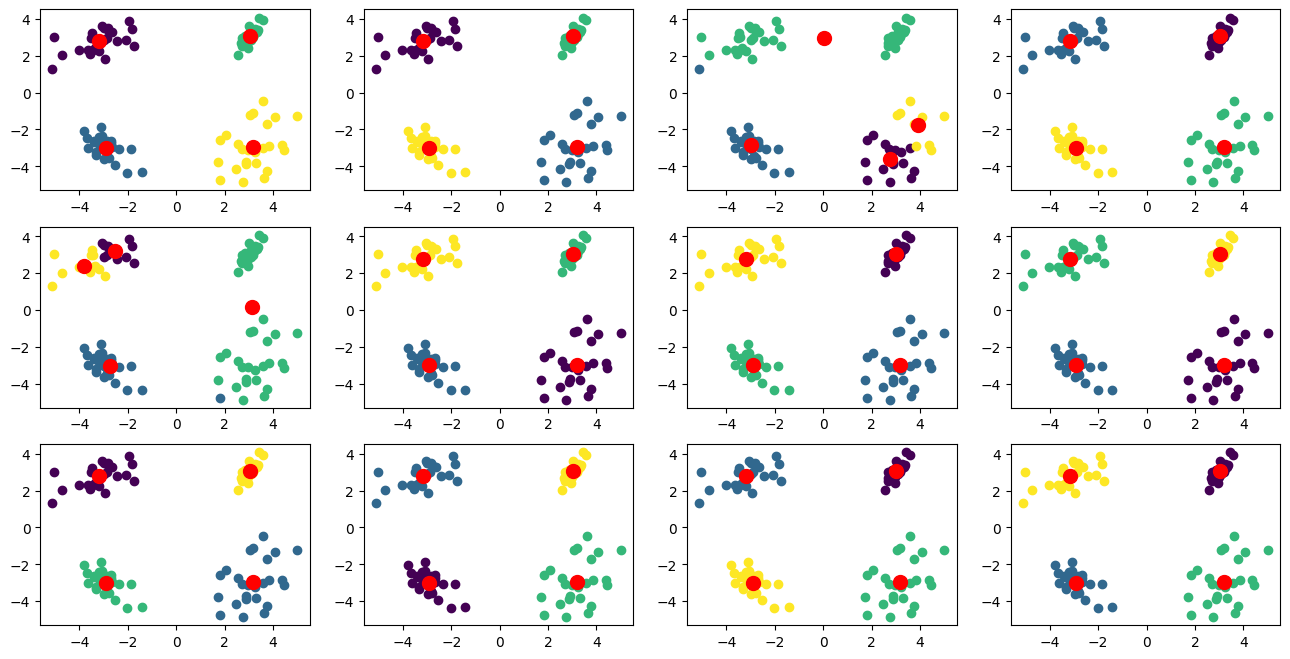

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 8))
for ax, _ in zip(axes.ravel(), range(12)):
    model = SuperInitKMeans(k=4, n_steps=10, n_models=15).fit(x)
    picture(model.predict(x), model.cluster_centers_, model.labels_, ax)

In [ ]:
# dbscan

In [ ]:
class DBScan:
  def __init__(self, eps=1, k=5):
    self.e, self.k = eps, k

  def fit(self, x):
